In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [5]:
encoding_used = "ISO-8859-1"
tweets_df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = encoding_used)
tweets_df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
data_columns  = ["target", "ids", "date", "flag", "user", "text"]
encoding_used = "ISO-8859-1"

tweets_df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = encoding_used, names = data_columns )
tweets_df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

**EDA**

In [8]:
target_group = tweets_df.groupby('target').count()['text']
target_group

target
0    800000
4    800000
Name: text, dtype: int64

Plotting distribution for dataset

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

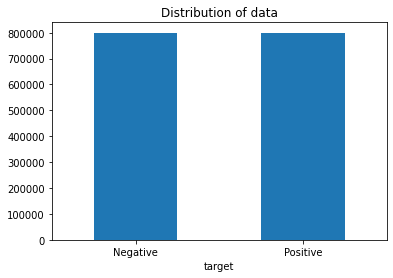

In [9]:
ax = target_group.plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation = 0)

Relevant Values

In [10]:
print(tweets_df.columns)

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [11]:
data = tweets_df[['target', 'text']]
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
data.columns = ["sentiment", "text"]
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
data[data['sentiment'] != 0].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [14]:
data['sentiment'] = data['sentiment'].replace(4,1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
data[data['sentiment'] != 0].head()

,sentiment,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


Finding the missing values

In [16]:
data.isnull().sum()

sentiment    0
text         0
dtype: int64

**Making a list from the data**

In [17]:
text, sentiment = list(data['text']), list(data['sentiment'])

Example

In [18]:
text[2:18]

['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i would've been the first, but i didn't have a gun.    not really though, zac snyder's just a doucheclown.",
 '@iamjazzyfizzle I wish I got to watch it with you!! I miss you and @iamlilnicki  how was the premiere?!',
 "Hollis' death scene w

In [19]:
sentiment[2:18]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**Preprocessing Text**
1. Replacing URLs
2. Lower Casing
3. Replacing Usernames
4. Replacing Emojis
5. Removing non-alphanets
6. Removing consecutive letters
7. Removing extremely short words (words with length less than 2)
8. Stopword removal
9. Lemmatization

Defining the Emojis into a dictionary

In [20]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

Custom List of Stopwords

In [21]:
mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [22]:
english_stop_words =  stopwords.words('english')
english_stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [23]:
stopwordlist = stopwords.words('english') + mystopwordlist

**Preprocessing Function**

In [24]:
def preprocess(textdata):
    processedText = []
    
    #creating a Lemmatizer
    wordLemma = WordNetLemmatizer() #define the imported library
    
    # Defining regular expression pattern we can find. in tweets
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # e.g check out https://dot.com for more
    userPattern       = '@[^\s]+' # e.g @FagbamigbeK check this out
    alphaPattern      = "[^a-zA-Z0-9]" # e.g I am *10 better!
    sequencePattern   = r"(.)\1\1+"  # e.g Heyyyyyyy, I am back!
    seqReplacePattern = r"\1\1" # e.g Replace Heyyyyyyy with Heyy
    
    
    for tweet in textdata:
        tweet = tweet.lower() #normalizing all text to a lower case
        
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet) #using the substitution method of the regular expression library
        
        
        # Replace all emojis.
        for emoji in emojis.keys(): #in each of the looped tweet, replace each emojis with their respective meaning
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  # emojis[emoji] helps to get the value of the emoji from the dictionary
            
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  #To hide Personal Information, we can replace all usernames with User
        
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet) # e.g I am *10 better!
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # e.g Replace Heyyyyyyy with Heyy
        
        
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
        
    return processedText

In [25]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [26]:
preprocessedtext = preprocess(text) 
print(f'Text Processing Done.')

Text Processing Done.


**Before Preprocessing**

In [27]:
text[0:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ']

**After Processing**

In [28]:
preprocessedtext[0:11]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ',
 'spring break plain city snowing ']

In [29]:
negative_sentiments = preprocessedtext[:800000]
negative_sentiments[0:10]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ']

In [30]:
data_neg = []
for words in negative_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_neg.append(words)
    
data_neg[0:10]

['  aww that bummer you shoulda got david carr third day emojiwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 ' dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 ' not behaving all mad why here because can see you all over there ',
 ' not the whole crew ',
 'need hug ',
 ' hey long time see yes rain bit only bit lol fine thanks how you ',
 ' nope they didn have ',
 ' que muera ']

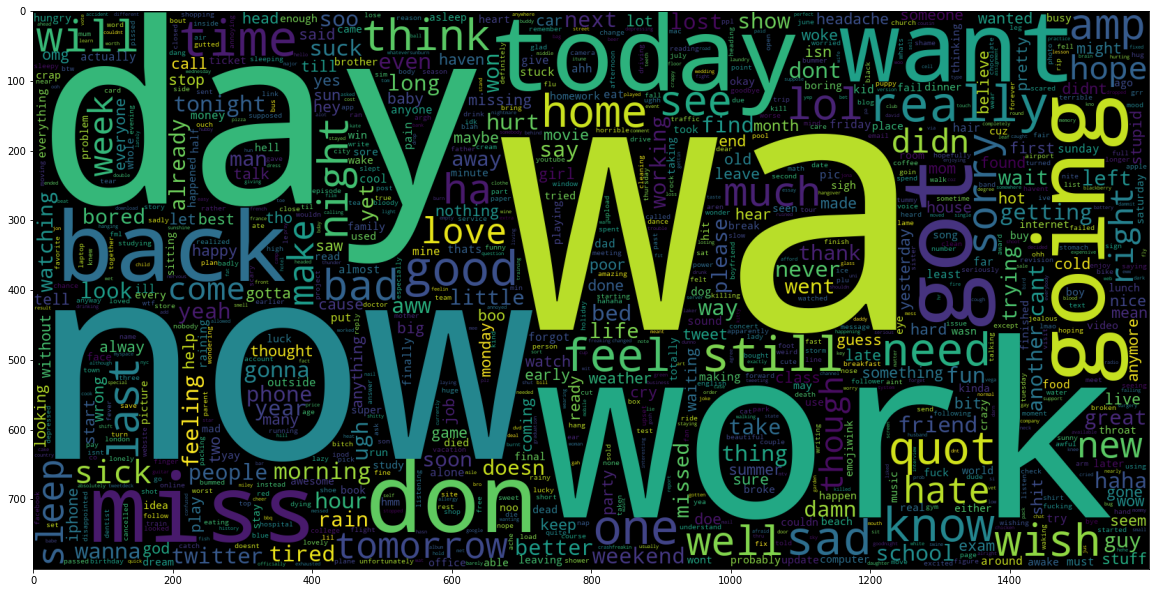

In [31]:
word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False)
plt.figure(figsize = (20,20))
negative_wc = word_cloud.generate(" ".join(data_neg))
plt.imshow(negative_wc)

**Word-Cloud for Positive tweets**

In [32]:
positive_sentiments = preprocessedtext[800000:]
positive_sentiments[0:10]

['love USER guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 'USER thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 'USER ha that effect everyone ',
 'USER you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 'USER thans for your response ihad already find this answer ',
 'USER jealous hope you had great time vega how did you like the acm love your show ',
 'USER congrats fletcher for finally joining twitter ',
 'USER responded stupid cat helping type forgive error ']

In [33]:
data_pos = []
for words in positive_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_pos.append(words)
    
data_pos[0:10]

['love  guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 ' thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 ' ha that effect everyone ',
 ' you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 ' thans for your response ihad already find this answer ',
 ' jealous hope you had great time vega how did you like the acm love your show ',
 ' congrats fletcher for finally joining twitter ',
 ' responded stupid cat helping type forgive error ']

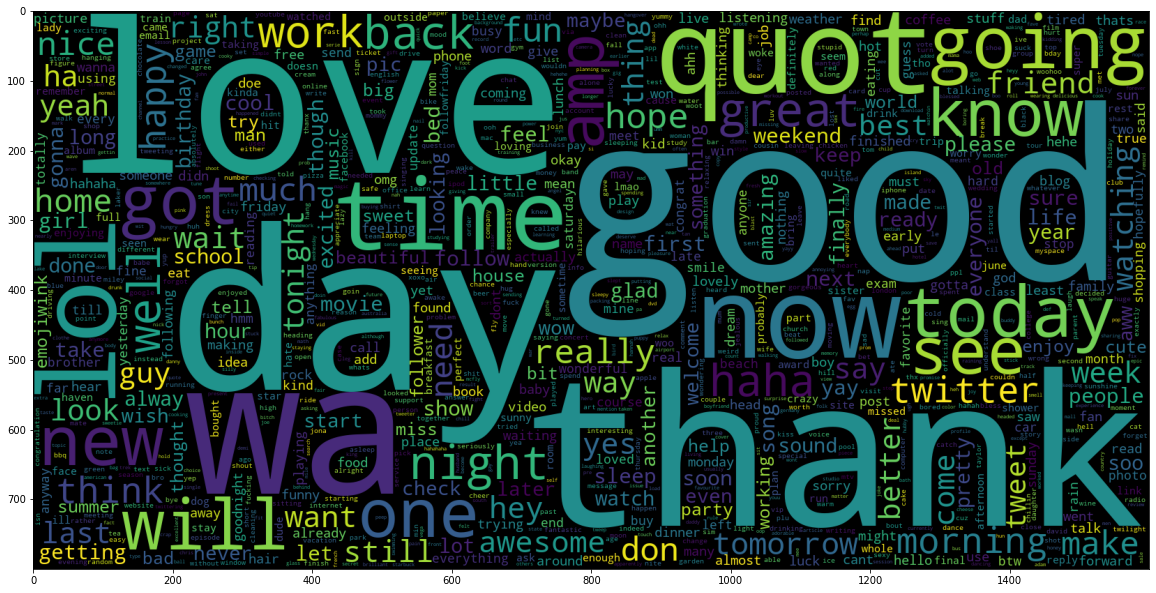

In [34]:
plt.figure(figsize = (20,20))
positive_wc = word_cloud.generate(" ".join(data_pos))
plt.imshow(positive_wc)

**Transforming the dataset before TF-IDF**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(preprocessedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')


Data Split done.


**TF-IDF**

In [36]:
vectoriser = TfidfVectorizer(ngram_range=(1,2),stop_words = stopwordlist, strip_accents = 'unicode', max_features = 500000)
vectoriser.fit(X_train) #fit the training data
print(f'Vectorised.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectorised.


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


**Transforming the dataset**

In [37]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


**Model Building and Evalution**

In [38]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

**Bernoulli Naive Bayes**

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.78      0.80      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



Text(0.5, 1.0, 'Confusion Matrix')

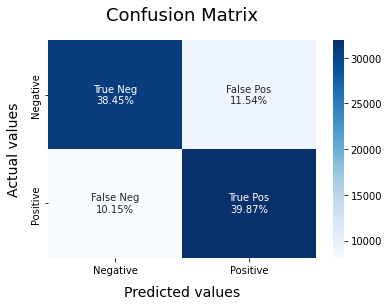

In [39]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
y_pred_bnb = BNBmodel.predict(X_test)
print(classification_report(y_test, y_pred_bnb))
cf_matrix = confusion_matrix(y_test, y_pred_bnb)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Linear SVC Model**

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.77      0.80      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



Text(0.5, 1.0, 'Confusion Matrix')

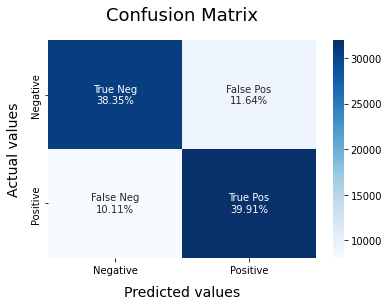

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_pred_svc = SVCmodel.predict(X_test)
print(classification_report(y_test, y_pred_svc))
cf_matrix = confusion_matrix(y_test, y_pred_svc)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



Text(0.5, 1.0, 'Confusion Matrix')

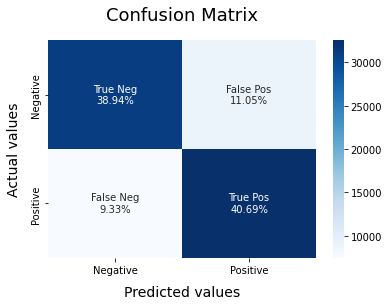

In [41]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred_lr = LRmodel.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cf_matrix = confusion_matrix(y_test, y_pred_lr)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Gradient Boosting**

In [42]:
"""from sklearn.ensemble import GradientBoostingClassifier
GRDBCmodel = GradientBoostingClassifier()
GRDBCmodel.fit(X_train, y_train)
y_pred_gbr = GRDBCmodel.predict(X_test)
print(classification_report(y_test, y_pred_gbr))
cf_matrix = confusion_matrix(y_test, y_pred_gbr)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)"""

'from sklearn.ensemble import GradientBoostingClassifier\nGRDBCmodel = GradientBoostingClassifier()\nGRDBCmodel.fit(X_train, y_train)\ny_pred_gbr = GRDBCmodel.predict(X_test)\nprint(classification_report(y_test, y_pred_gbr))\ncf_matrix = confusion_matrix(y_test, y_pred_gbr)\ncategories  = [\'Negative\',\'Positive\']\ngroup_names = [\'True Neg\',\'False Pos\', \'False Neg\',\'True Pos\']\ngroup_percentages = [\'{0:.2%}\'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]\nlabels = [f\'{v1}\n{v2}\' for v1, v2 in zip(group_names,group_percentages)]\nlabels = np.asarray(labels).reshape(2,2)\nsns.heatmap(cf_matrix, annot = labels, cmap = \'Blues\',fmt = \'\',\n                xticklabels = categories, yticklabels = categories)\nplt.xlabel("Predicted values", fontdict = {\'size\':14}, labelpad = 10)\nplt.ylabel("Actual values"   , fontdict = {\'size\':14}, labelpad = 10)\nplt.title ("Confusion Matrix", fontdict = {\'size\':18}, pad = 20)'

**Naive Bayes**

              precision    recall  f1-score   support

           0       0.79      0.78      0.78     39989
           1       0.78      0.79      0.79     40011

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



Text(0.5, 1.0, 'Confusion Matrix')

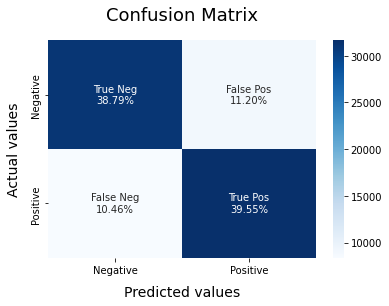

In [43]:
from sklearn.naive_bayes import MultinomialNB
NBClassifier_model = MultinomialNB()
NBClassifier_model.fit(X_train, y_train)
y_pred_nb = NBClassifier_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))
cf_matrix = confusion_matrix(y_test, y_pred_nb)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**LightGBM**

In [ ]:
"""LGBMmodel = LGBMClassifier()
LGBMmodel.fit(X_train, y_train)
model_Evaluate(LGBMmodel)
y_pred_lgb = LGBmodel.predict(X_test)
print(classification_report(y_test, y_pred_lgb))
cf_matrix = confusion_matrix(y_test, y_pred_lgb)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)"""

**CatBoost Model**

In [ ]:
"""
CatBoostmodel = CatBoostClassifier(cat_features = preprocessedtext, eval_metric = (X_test, y_test))
CatBoostmodel.fit(X_train, y_train)
model_Evaluate(CatBoostmodel)
y_pred_cat = CatBoostmodel.predict(X_test)
print(classification_report(y_test, y_pred_cat))
cf_matrix = confusion_matrix(y_test, y_pred_cat)
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)"""